In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_union
from sklearn.compose import make_column_selector
from sklearn.preprocessing import FunctionTransformer
from sklearn import set_config; set_config(display='diagram')

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split

import joblib

In [2]:
## Load CSV
path_from = "raw_data/cluster_data_clean_latlng.csv"
df_group = pd.read_csv(path_from, delimiter=',', low_memory=False, encoding = 'utf-8')

## Build PCA Pipeline

In [3]:
df_group.head()

,Store ID,Item ID,Store Category,Store Segment,Store Region,City,Item Price,Region Language,Region Type,lat,lng
0,35,34,Indie - Outbound,Bakery,Vaud,Salavaux,6.9,french,urban,46.918363,7.022345
1,57,73,Indie - Outbound,Bakery,Freiburg,Sâles,6.9,french,urban,46.641510,7.062369
2,58,337173,Indie - Outbound,Bakery,Freiburg,Ursy,4.9,french,urban,46.637755,6.843907
3,61,79,Indie - Outbound,Traditional Restaurant,Vaud,Lausanne,6.9,french,urban,46.531848,6.638594
4,62,78,Indie - Outbound,Traditional Restaurant,Bern,Bern,5.9,german,urban,46.907301,7.490900


In [55]:
num_transformer = make_pipeline(RobustScaler())
cat_transformer = make_pipeline(OneHotEncoder(handle_unknown='ignore',sparse=False))

preprocess = make_column_transformer((num_transformer, ['Item Price', 'lat', 'lng']), 
                                     (cat_transformer,['Store Category', 'Store Segment', 'Region Language']))

In [63]:
## Transform Data
df_group_trans= preprocess.fit_transform(df_group)

## PCA Process
pca = PCA()
pca.fit(df_group_trans)
X_proj = pca.transform(df_group_trans)
X_proj = pd.DataFrame(X_proj)

## Modelling
km = KMeans(n_clusters=5)
km.fit(X_proj)
wo_pipe=km.labels_

## KMeans

In [64]:
pipe = make_pipeline(preprocess, PCA(), KMeans(n_clusters=5))
pipe.fit(df_group)
w_pipe = pipe[-1].labels_

In [65]:
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Item Price', 'lat', 'lng']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Store Category',
                                                   'Store Segment',
                                                   'Region Language'])])),
                ('pca', PCA()), ('kmeans', KMeans(n_clusters=5))])

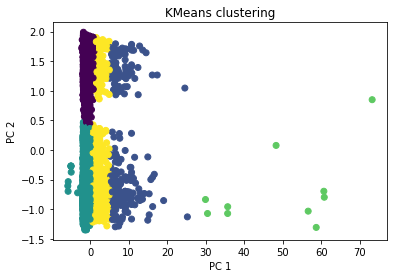

In [66]:
plt.scatter(X_proj.iloc[:,0], X_proj.iloc[:,1], c=pipe[-1].labels_)
plt.title('KMeans clustering'); plt.xlabel('PC 1'); plt.ylabel('PC 2');

In [67]:
## Save new defined Clusters

## Extend Cluster to initial DF
df_group['Cluster'] = km.labels_

# df.to_csv('raw_data/full_data_clean_inclCluster.csv')
df_group.to_csv('raw_data/group_data_clean_inclCluster.csv')

Text(0.5, 0, 'k cluster number')

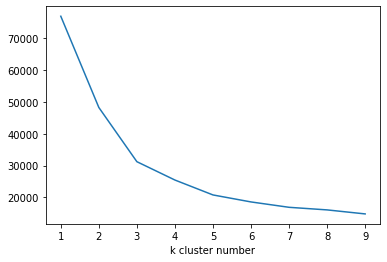

In [68]:
## Calculate optimal Cluster-Size
inertias = []
ks = range(1,10)
for k in ks:
    km_test = KMeans(n_clusters=k).fit(X_proj)
    inertias.append(km_test.inertia_)
plt.plot(ks, inertias)
plt.xlabel('k cluster number')

In [69]:
unique, counts = np.unique(w_pipe, return_counts=True)

print(np.asarray((unique, counts)).T)

[[   0 1727]
 [   1  268]
 [   2 3699]
 [   3   10]
 [   4  929]]


In [87]:
def predict(item_price, address, store_category, store_segment, region_language):
    lat, lng = get_geo(address)
    df = pd.DataFrame({'Item Price': item_price: , 'lat' = lat, 'lng' = lng, 'Store Category': store_category, 'Store Segment': store_segment, 'Region Language': region_language})
    
    ## Extend Cluster to initial DF
    pipe = joblib.load('cluster_model.joblib')
    pipe.predict(df)

    return pipe.labels_

SyntaxError: invalid syntax (3843282656.py, line 3)

In [91]:
df = pd.DataFrame({'Item Price': [9.8] , 'lat': [10.8], 'lng': [5.9], 'Store Category': ['Indie - Outbound'], 'Store Segment': ['Buffet'], 'Region Language': ['french']})

In [94]:
pipe.predict(df)[0]

0

In [95]:
def save_model():
    """Save the model into a .joblib format"""
    joblib.dump(pipe, 'cluster_model.joblib')

In [96]:
save_model()